## Training DynEdge

Now that both database and selection is ready, everything is in place to begin training. DynEdge is a GNN implemented in GraphNeT - it represents IceCube events as 3D point clouds and leverages techniques from segmentation analysis in computer vision to reconstruct events. You can find technical details on the model in [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003). The model and training configuration shown below is nearly identical to what's presented in the paper. Note that this configuration was originally meant for low energy, so it's possible that some adjustments might improve performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from graphnet.data.constants import FEATURES, TRUTH

from icecube_utils import (
    load_pretrained_model,
    inference, 
    train_dynedge_from_scratch,
    get_acts_wassersteinized_layers_modularized,
    compute_activations_across_models_v1
)
from icecube_utils import make_dataloader
from graphnet.training.labels import Direction
from parameters import get_parser
from train_large import config

features = FEATURES.KAGGLE
truth = TRUTH.KAGGLE

graphnet: INFO     2023-03-04 16:26:14 - get_logger - Writing log to logs/graphnet_20230304-162614.log


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


graphnet: WARNING  2023-03-04 16:26:16 - warn_once - `icecube` not available. Some functionality may be missing.


In the cell below, you can choose between training dynedge from scratch on the batch_1 database or loading in a pretrained model that has trained on batches 1 to 50.

In [31]:
config_small = deepcopy(config)
config_small['dynedge']['dynedge_layer_sizes'] = [(128, 256), (336, 256), (336, 256), (336, 256)]

model_small_seed_0 = load_pretrained_model(config=config_small, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_small_0/state_dict.pth')
model_small_seed_1 = load_pretrained_model(config=config_small, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_small_1/state_dict.pth')

In [32]:
# config_large = deepcopy(config)
# config_large['dynedge']['dynedge_layer_sizes'] = [(128 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2)]

# model_large = load_pretrained_model(config=config_large, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_large/state_dict.pth')

In [33]:
model_small_seed_0

StandardModel(
  (_detector): IceCubeKaggle(
    (_graph_builder): KNNGraphBuilder()
  )
  (_gnn): DynEdge(
    (_activation): LeakyReLU(negative_slope=0.01)
    (_conv_layers): ModuleList(
      (0): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=34, out_features=128, bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=128, out_features=256, bias=False)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (1): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=512, out_features=336, bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=336, out_features=256, bias=False)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (2): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=512, out_features=336, bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=336, out_features=256, bias=False)
        (3): LeakyReLU(negative_slope=0.01)
      ))
    

In [34]:
# model_large

In [35]:
# %%capture --no-stdout
# config_large_random = deepcopy(config_large)
# config_large_random['fit']['max_steps'] = 0
# model_large_random = train_dynedge_from_scratch(config=config_large_random)

In [36]:
# [name for name, _ in model_large_random.named_parameters()]

In [37]:
parser = get_parser()
args = parser.parse_args('--gpu-id 1 --model-name mlpnet --n-epochs 10 --save-result-file sample.csv \
--sweep-name exp_sample --exact --correction --ground-metric euclidean --weight-stats \
--activation-histograms --activation-mode raw --geom-ensemble-type acts --sweep-id 21 \
--act-num-samples 200 --ground-metric-normalize none --activation-seed 21 \
--prelu-acts --recheck-acc --load-models ./mnist_models --ckpt-type final \
--past-correction --not-squared --dist-normalize --print-distances --to-download'.split())

args.gpu_id = 0
args.proper_marginals = True
args.skip_last_layer = True
args.skip_personal_idx = False
args.act_num_samples = 20
args.width_ratio = 1
args.dataset = 'icecube'

In [38]:
train_dataloader = make_dataloader(db = config_small['path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = args.act_num_samples,
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
)

In [39]:
[x[0] for x in model_small_seed_0.named_parameters()]

['_gnn._conv_layers.0.nn.0.weight',
 '_gnn._conv_layers.0.nn.2.weight',
 '_gnn._conv_layers.1.nn.0.weight',
 '_gnn._conv_layers.1.nn.2.weight',
 '_gnn._conv_layers.2.nn.0.weight',
 '_gnn._conv_layers.2.nn.2.weight',
 '_gnn._conv_layers.3.nn.0.weight',
 '_gnn._conv_layers.3.nn.2.weight',
 '_gnn._post_processing.0.weight',
 '_gnn._post_processing.2.weight',
 '_gnn._readout.0.weight',
 '_tasks.0._affine.weight']

In [40]:
{name: x.shape for name, x in model_small_seed_0.named_parameters()}

{'_gnn._conv_layers.0.nn.0.weight': torch.Size([128, 34]),
 '_gnn._conv_layers.0.nn.2.weight': torch.Size([256, 128]),
 '_gnn._conv_layers.1.nn.0.weight': torch.Size([336, 512]),
 '_gnn._conv_layers.1.nn.2.weight': torch.Size([256, 336]),
 '_gnn._conv_layers.2.nn.0.weight': torch.Size([336, 512]),
 '_gnn._conv_layers.2.nn.2.weight': torch.Size([256, 336]),
 '_gnn._conv_layers.3.nn.0.weight': torch.Size([336, 512]),
 '_gnn._conv_layers.3.nn.2.weight': torch.Size([256, 336]),
 '_gnn._post_processing.0.weight': torch.Size([336, 1041]),
 '_gnn._post_processing.2.weight': torch.Size([256, 336]),
 '_gnn._readout.0.weight': torch.Size([128, 768]),
 '_tasks.0._affine.weight': torch.Size([3, 128])}

In [41]:
# import torch

# models = [
#     model_small_seed_0.cuda(),
#     model_large.cuda(), 
# ]
# layer_names = {
#     '_gnn._conv_layers.0.nn.0',
#     '_gnn._conv_layers.0.nn.2',
#     '_gnn._conv_layers.1.nn.0',
#     '_gnn._conv_layers.1.nn.2',
#     '_gnn._conv_layers.2.nn.0',
#     '_gnn._conv_layers.2.nn.2',
#     '_gnn._conv_layers.3.nn.0',
#     '_gnn._conv_layers.3.nn.2',
#     '_gnn._post_processing.0',
#     '_gnn._post_processing.2',
#     '_gnn._readout.0',
#     '_tasks.0._affine',
# }
# with torch.no_grad():
#     activations = compute_activations.compute_activations_across_models_v1(
#         args, 
#         models,
#         train_dataloader,
#         args.act_num_samples,
#         mode=args.activation_mode,
#         layer_names=layer_names
#     )
#     _, model_large_mapped_state_dict = get_acts_wassersteinized_layers_modularized(args, models, activations, train_loader=train_dataloader, test_loader=None)
    
# model_large_mapped = deepcopy(model_large)
# model_large_mapped.load_state_dict(model_large_mapped_state_dict)

In [42]:
import torch

models = [
    model_small_seed_0.cuda(),
    model_small_seed_1.cuda(), 
]
layer_names = {
    '_gnn._conv_layers.0.nn.0',
    '_gnn._conv_layers.0.nn.2',
    '_gnn._conv_layers.1.nn.0',
    '_gnn._conv_layers.1.nn.2',
    '_gnn._conv_layers.2.nn.0',
    '_gnn._conv_layers.2.nn.2',
    '_gnn._conv_layers.3.nn.0',
    '_gnn._conv_layers.3.nn.2',
    '_gnn._post_processing.0',
    '_gnn._post_processing.2',
    '_gnn._readout.0',
    '_tasks.0._affine',
}
with torch.no_grad():
    activations = compute_activations_across_models_v1(
        args, 
        models,
        train_dataloader,
        args.act_num_samples,
        mode=args.activation_mode,
        layer_names=layer_names
    )
    _, model_small_mapped_state_dict, _ = get_acts_wassersteinized_layers_modularized(args, models, activations, train_loader=train_dataloader, test_loader=None)
    
model_small_mapped_state_dict = {
    k: v[:, 0] if 'bias' in k else v for k, v in model_small_mapped_state_dict.items()
}

model_small_mapped = deepcopy(model_small_seed_0)
model_small_mapped.load_state_dict(model_small_mapped_state_dict)

set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0
set forward hook for layer named:  _gnn._conv_layers.2.nn.2
set forward hook for layer named:  _gnn._conv_layers.3.nn.0
set forward hook for layer named:  _gnn._conv_layers.3.nn.2
set forward hook for layer named:  _gnn._post_processing.0
set forward hook for layer named:  _gnn._post_processing.2
set forward hook for layer named:  _gnn._readout.0
set forward hook for layer named:  _tasks.0._affine
set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [9666], which does not match the required output shape [1611, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [26346], which does not match the required output shape [4391, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

graphnet: INFO     2023-03-04 16:54:30 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [7488], which does not match the required output shape [1248, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [107964], which does not match the required output shape [17994, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resiz

num_personal_idx  0
model_name is  mlpnet
***********
min of act: -1.1325409412384033, max: 1.041191577911377, mean: -0.08256817609071732
activations for idx 0 at layer _gnn._conv_layers.0.nn.0 have the following shape  torch.Size([12844, 128])
-----------
***********
min of act: -0.9590854644775391, max: 0.9545163512229919, mean: -0.03809298202395439
activations for idx 0 at layer _gnn._conv_layers.0.nn.2 have the following shape  torch.Size([12844, 256])
-----------
***********
min of act: -17.302310943603516, max: 24.802783966064453, mean: -0.6187565326690674
activations for idx 0 at layer _gnn._conv_layers.1.nn.0 have the following shape  torch.Size([12784, 336])
-----------
***********
min of act: -23.767757415771484, max: 27.966615676879883, mean: -0.5973536968231201
activations for idx 0 at layer _gnn._conv_layers.1.nn.2 have the following shape  torch.Size([12784, 256])
-----------
***********
min of act: -227.503662109375, max: 169.9368133544922, mean: -3.1012747287750244
acti

<All keys matched successfully>

In [43]:
torch.cuda.empty_cache()

In [44]:
activations[0]['_gnn._conv_layers.0.nn.0'].shape

torch.Size([12844, 128])

In [18]:
# _, model_small_mapped_state_dict, T_vars = get_wassersteinized_layers_modularized(
#     args, 
# )
# model_small_mapped = deepcopy(model_small)
# model_small_mapped.load_state_dict(model_small_mapped_state_dict)

# _, model_large_mapped_reverse_state_dict, _ = get_wassersteinized_layers_modularized(
#     args, 
#     [
#         model_small.cuda(), 
#         model_large.cuda()
#     ],
#     T_vars_pre_computed={name: T_var.t() for name, T_var in T_vars.items()}
# )
# model_large_mapped_reverse = deepcopy(model_large)
# model_large_mapped_reverse.load_state_dict(model_large_mapped_reverse_state_dict)

In [19]:
# _, model_large_mapped_state_dict, _ = get_wassersteinized_layers_modularized(
#     args, 
#     [
#         model_small.cuda(), 
#         model_large.cuda()
#     ],
# )
# model_large_mapped = deepcopy(model_large)
# model_large_mapped.load_state_dict(model_large_mapped_state_dict)

In [20]:
# params = [
#     model_small_seed_0.named_parameters(), 
#     model_small_seed_1.named_parameters(), 
#     model_small_mapped.named_parameters(),
# ]
# for x in zip(*params):
#     fig, axes = plt.subplots(1, len(params), figsize=(10, 5), sharey=True)
#     for i, (name, weight) in enumerate(x):
#         if 'bias' in name:
#             axes[i].plot(
#                 np.arange(weight.shape[0]),
#                 weight.detach().cpu().numpy()
#             )
#         else:
#             axes[i].imshow(
#                 weight.detach().cpu().numpy(),
#                 vmin=-0.5, vmax=0.5,
#             )

In [45]:
model_small_seed_0._gnn._conv_layers[0].nn[0].weight[0], \
model_small_mapped._gnn._conv_layers[0].nn[0].weight[0]

(tensor([-0.0530, -0.1469, -0.1048,  0.1852, -0.1085,  0.2784,  0.1137,  0.2068,
          0.1482, -0.1085,  0.1014, -0.0917,  0.0532, -0.0614, -0.1515,  0.0441,
         -0.0602,  0.0328, -0.0102, -0.0710, -0.1892,  0.0350, -0.0676, -0.0358,
         -0.1423,  0.1702, -0.0578,  0.0553, -0.0765,  0.0198, -0.1400,  0.0411,
         -0.0971,  0.1189], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([ 0.0592, -0.0325, -0.0560,  0.1376,  0.0220, -0.0754,  0.0539, -0.0014,
          0.1079,  0.0142,  0.1590,  0.0406, -0.0791, -0.0406,  0.0911, -0.1039,
         -0.1335, -0.0583,  0.1291,  0.0313,  0.0489, -0.1116, -0.1421, -0.0928,
         -0.0863,  0.1237,  0.0294,  0.1425, -0.1004, -0.0194, -0.0923,  0.0748,
         -0.1019,  0.0643], device='cuda:0', grad_fn=<SelectBackward0>))

In [46]:
model_small_seed_0._gnn._conv_layers[0].nn[0].weight[0].shape, \
model_small_mapped._gnn._conv_layers[0].nn[0].weight[0].shape

(torch.Size([34]), torch.Size([34]))

In [47]:
model_small_seed_0._tasks[0]._affine.weight[0], \
model_small_mapped._tasks[0]._affine.weight[0]

(tensor([-5.5422e-02,  1.2409e-02,  3.4268e-01, -5.2319e-02,  4.1751e-02,
          3.1666e-01, -1.7304e-02, -1.4648e-02, -5.8049e-02,  2.4111e-02,
         -5.2591e-02, -1.3277e-01,  5.5905e-03, -1.6703e-05, -3.2380e-02,
          4.2373e-02, -4.0024e-02,  2.9388e-02, -9.5711e-02, -6.8628e-02,
         -5.1296e-02, -5.2771e-02,  2.4813e-01,  4.2263e-02,  1.2523e-01,
         -1.0018e-01,  1.5632e-02,  5.8656e-02, -5.3551e-02,  1.5514e-02,
          1.1255e-02, -1.7243e-01, -5.0776e-03, -3.0026e-02, -1.8836e-01,
          2.5555e-02, -2.3483e-02,  6.7010e-03, -5.8110e-03,  1.8280e-02,
          1.7379e-02,  2.5022e-03, -1.9172e-02,  5.7347e-02, -2.0770e-02,
          1.3322e-02, -1.0614e-01, -1.7546e-01,  3.2631e-02,  7.0473e-02,
         -3.5992e-02, -4.3566e-02,  2.5476e-02, -6.0702e-02,  1.8344e-01,
          7.5087e-02,  1.1981e-02, -2.4757e-02,  7.1812e-02, -4.1169e-03,
         -1.0661e-01, -3.6065e-01, -6.7432e-02,  2.9074e-02,  5.8925e-03,
         -5.2571e-02, -4.7496e-02, -1.

In [48]:
model_small_seed_0._tasks[0]._affine.weight.shape, \
model_small_mapped._tasks[0]._affine.weight.shape

(torch.Size([3, 128]), torch.Size([3, 128]))

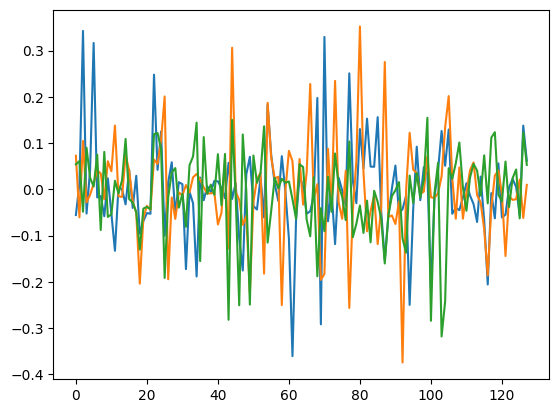

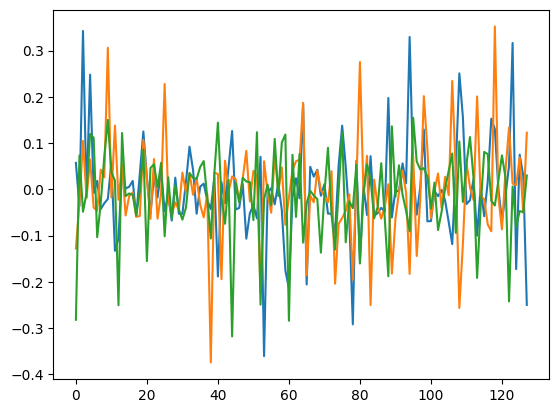

In [49]:
plt.plot(model_small_seed_0._tasks[0]._affine.weight.detach().cpu().numpy().T)
plt.figure()
plt.plot(model_small_mapped._tasks[0]._affine.weight.detach().cpu().numpy().T)

In [50]:
plt.plot(model_small_seed_0._tasks[0]._affine.bias.detach().cpu().numpy().T)
plt.figure()
plt.plot(model_small_mapped._tasks[0]._affine.bias.detach().cpu().numpy().T)

AttributeError: 'NoneType' object has no attribute 'detach'

In [51]:
tol = 1e-5
for idx, ((layer0_name, fc_layer0_weight), (layer1_name, fc_layer1_weight)) in \
        enumerate(zip(model_small_seed_0.named_parameters(), model_small_mapped.named_parameters())):
    with torch.no_grad():
        if not (
            torch.allclose(fc_layer0_weight.mean(), fc_layer1_weight.mean(), rtol=tol, atol=tol) and
            torch.allclose(fc_layer0_weight.abs().mean(), fc_layer1_weight.abs().mean(), rtol=tol, atol=tol) and 
            torch.allclose((fc_layer0_weight.abs() ** 2).mean(), (fc_layer1_weight.abs() ** 2).sum() ** 0.5, rtol=tol, atol=tol)
        ):
            print(layer0_name, fc_layer0_weight.mean(), fc_layer1_weight.mean())

_gnn._conv_layers.0.nn.0.weight tensor(-0.0032, device='cuda:0') tensor(-0.0032, device='cuda:0')
_gnn._conv_layers.0.nn.2.weight tensor(-0.0022, device='cuda:0') tensor(-0.0022, device='cuda:0')
_gnn._conv_layers.1.nn.0.weight tensor(-0.0019, device='cuda:0') tensor(-0.0019, device='cuda:0')
_gnn._conv_layers.1.nn.2.weight tensor(-0.0049, device='cuda:0') tensor(-0.0049, device='cuda:0')
_gnn._conv_layers.2.nn.0.weight tensor(-0.0024, device='cuda:0') tensor(-0.0024, device='cuda:0')
_gnn._conv_layers.2.nn.2.weight tensor(-0.0065, device='cuda:0') tensor(-0.0065, device='cuda:0')
_gnn._conv_layers.3.nn.0.weight tensor(-0.0015, device='cuda:0') tensor(-0.0015, device='cuda:0')
_gnn._conv_layers.3.nn.2.weight tensor(-0.0047, device='cuda:0') tensor(-0.0047, device='cuda:0')
_gnn._post_processing.0.weight tensor(-0.0010, device='cuda:0') tensor(-0.0010, device='cuda:0')
_gnn._post_processing.2.weight tensor(-0.0024, device='cuda:0') tensor(-0.0024, device='cuda:0')
_gnn._readout.0.weight

In [28]:
# with torch.no_grad():
#     model_mapped._gnn._post_processing[0].weight /= 0.5 / 0.7071667
#     model_mapped._gnn._post_processing[2].weight /= 0.5 / 1.0000592
#     model_mapped._gnn._readout[0].weight /= 0.5 / 1.0000384
#     model_mapped._tasks[0]._affine.weight /= 0.7 / 1.0000129

In [52]:
import torch

models = [
    model_small_mapped.cuda(), 
    model_small_seed_0.cuda(),
    model_small_seed_1.cuda(), 
]
layer_names = {
    '_gnn._conv_layers.0.nn.0',
    '_gnn._conv_layers.0.nn.2',
    '_gnn._conv_layers.1.nn.0',
    '_gnn._conv_layers.1.nn.2',
    '_gnn._conv_layers.2.nn.0',
    '_gnn._conv_layers.2.nn.2',
    '_gnn._conv_layers.3.nn.0',
    '_gnn._conv_layers.3.nn.2',
    '_gnn._post_processing.0',
    '_gnn._post_processing.2',
    '_gnn._readout.0',
    '_tasks.0._affine',
}
with torch.no_grad():
    activations = compute_activations_across_models_v1(
        args, 
        models,
        train_dataloader,
        args.act_num_samples,
        mode=args.activation_mode,
        layer_names=layer_names
    )

set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0
set forward hook for layer named:  _gnn._conv_layers.2.nn.2
set forward hook for layer named:  _gnn._conv_layers.3.nn.0
set forward hook for layer named:  _gnn._conv_layers.3.nn.2
set forward hook for layer named:  _gnn._post_processing.0
set forward hook for layer named:  _gnn._post_processing.2
set forward hook for layer named:  _gnn._readout.0
set forward hook for layer named:  _tasks.0._affine
set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0

_gnn._conv_layers.0.nn.0 [torch.Size([12844, 128]), torch.Size([12844, 128]), torch.Size([12844, 128])]
_gnn._conv_layers.0.nn.0 [-1.1325262784957886, -1.1325409412384033, -1.3195627927780151]
_gnn._conv_layers.0.nn.0 [1.0411782264709473, 1.041191577911377, 1.1776950359344482]
_gnn._conv_layers.0.nn.2 [torch.Size([12844, 256]), torch.Size([12844, 256]), torch.Size([12844, 256])]
_gnn._conv_layers.0.nn.2 [-0.9590364098548889, -0.9590854644775391, -1.3239096403121948]
_gnn._conv_layers.0.nn.2 [0.9544675946235657, 0.9545163512229919, 1.00206458568573]
_gnn._conv_layers.1.nn.0 [torch.Size([12784, 336]), torch.Size([12784, 336]), torch.Size([12784, 336])]
_gnn._conv_layers.1.nn.0 [-16.116701126098633, -17.302310943603516, -15.780616760253906]
_gnn._conv_layers.1.nn.0 [18.454345703125, 24.802783966064453, 14.602896690368652]
_gnn._conv_layers.1.nn.2 [torch.Size([12784, 256]), torch.Size([12784, 256]), torch.Size([12784, 256])]
_gnn._conv_layers.1.nn.2 [-18.077966690063477, -23.76775932312011

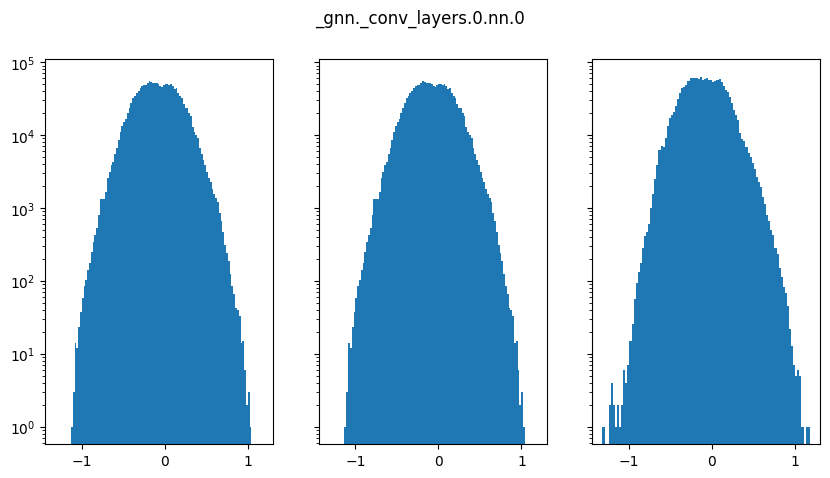

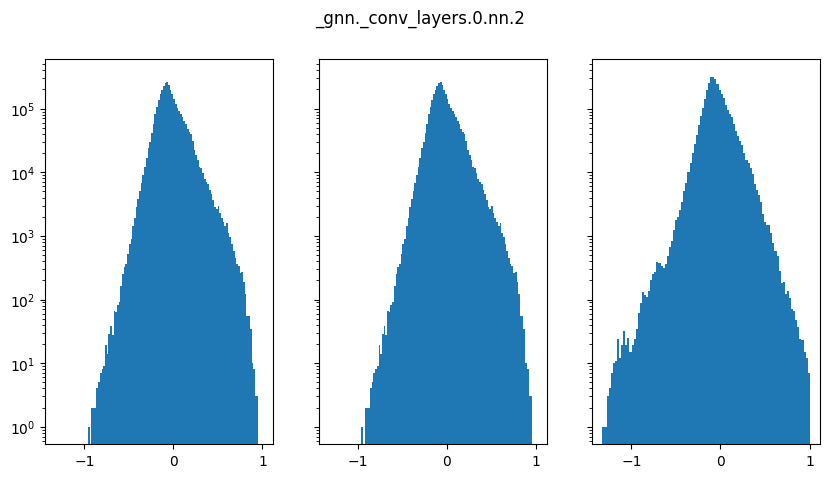

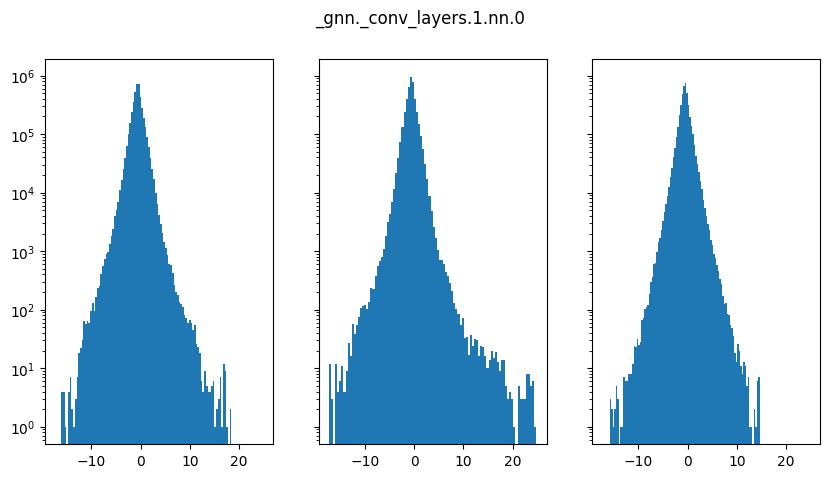

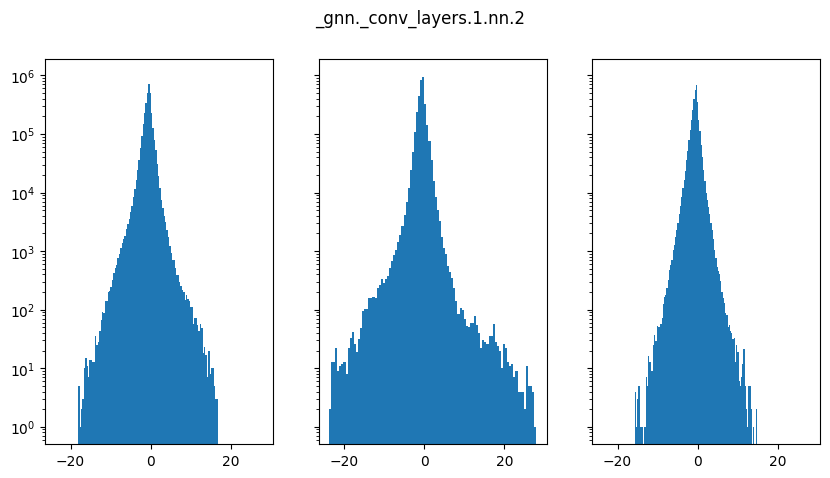

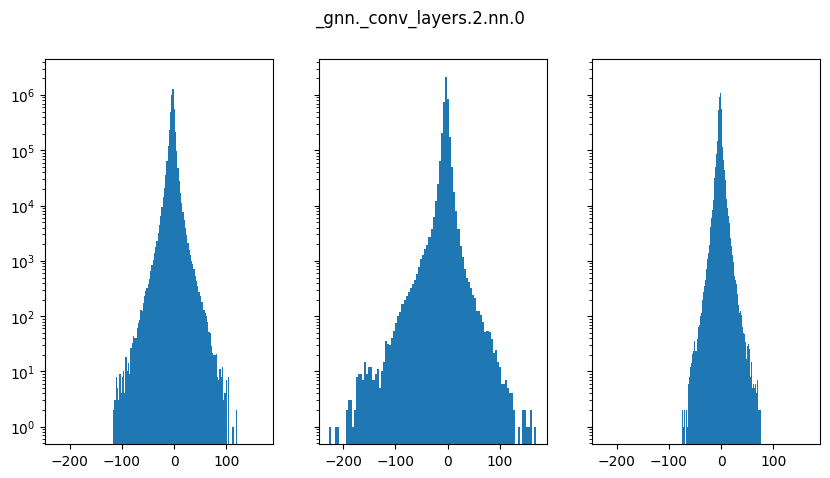

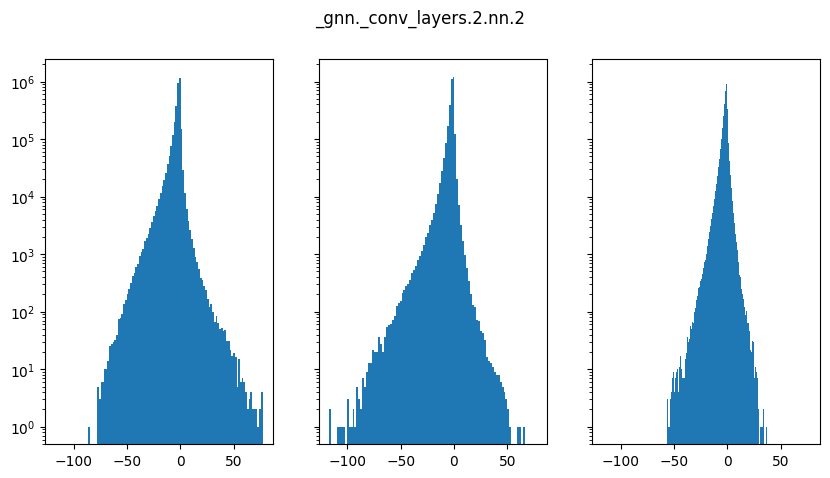

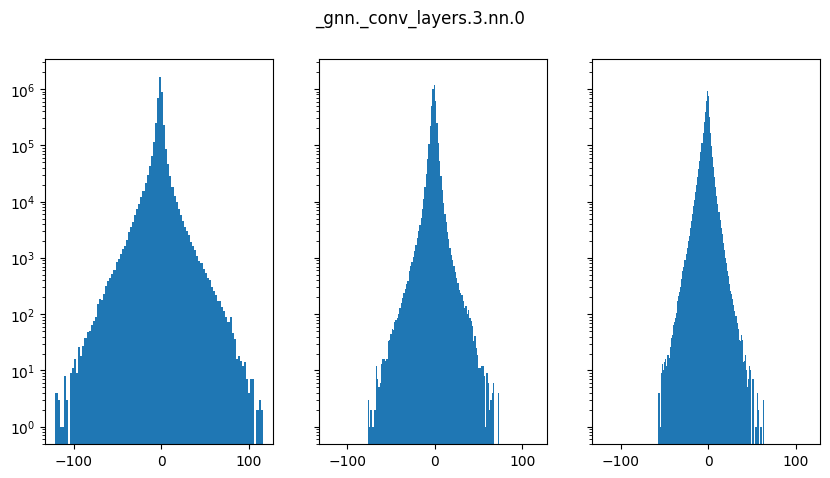

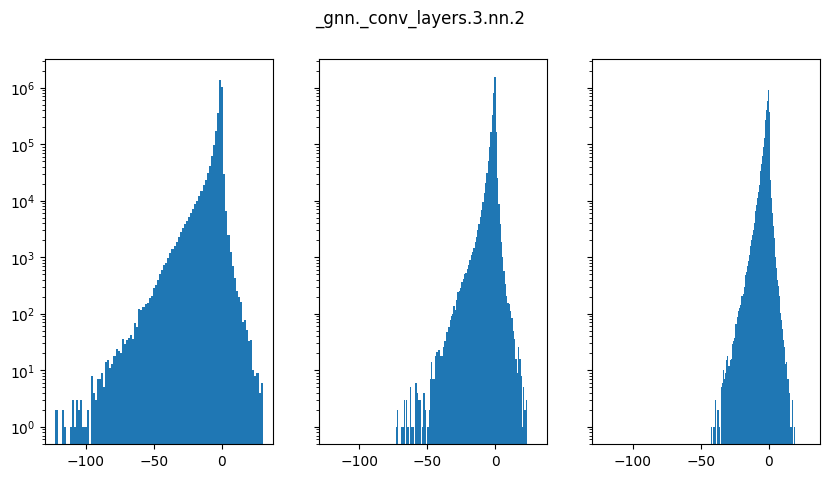

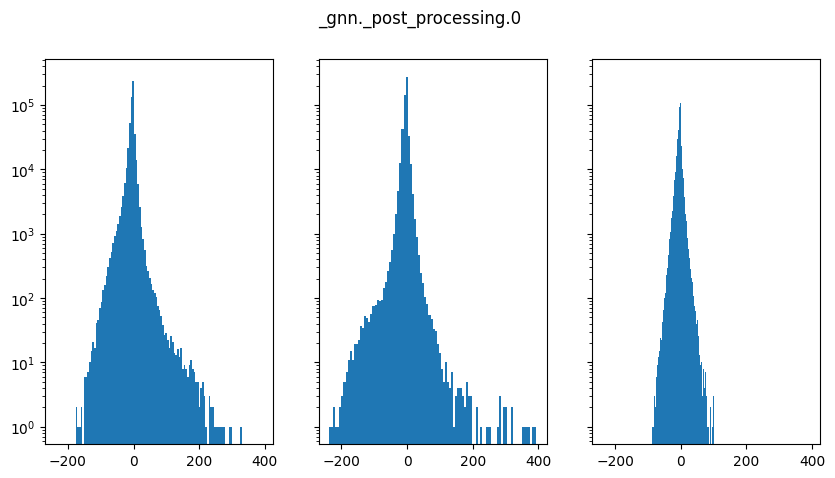

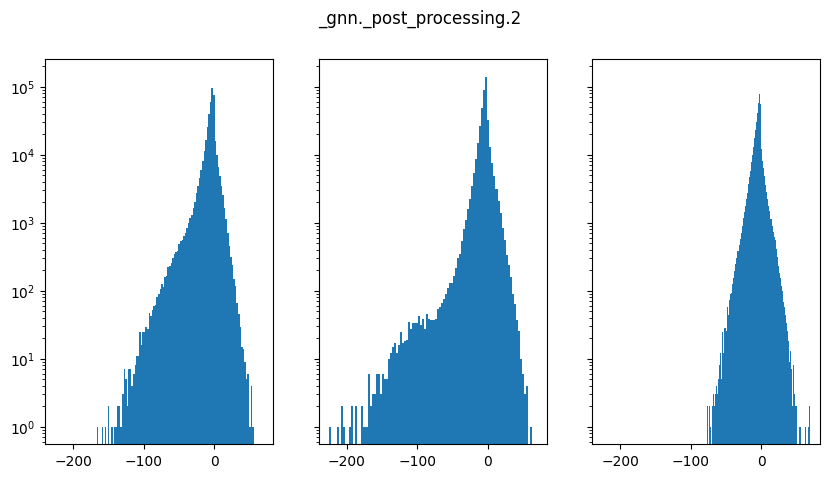

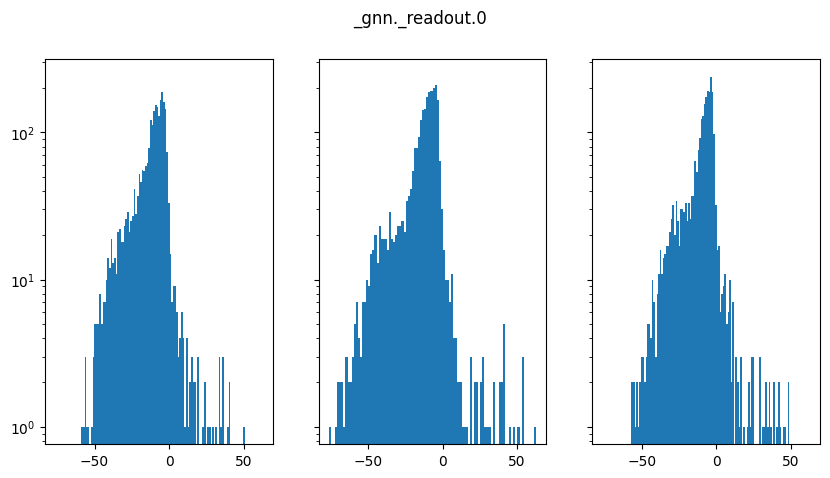

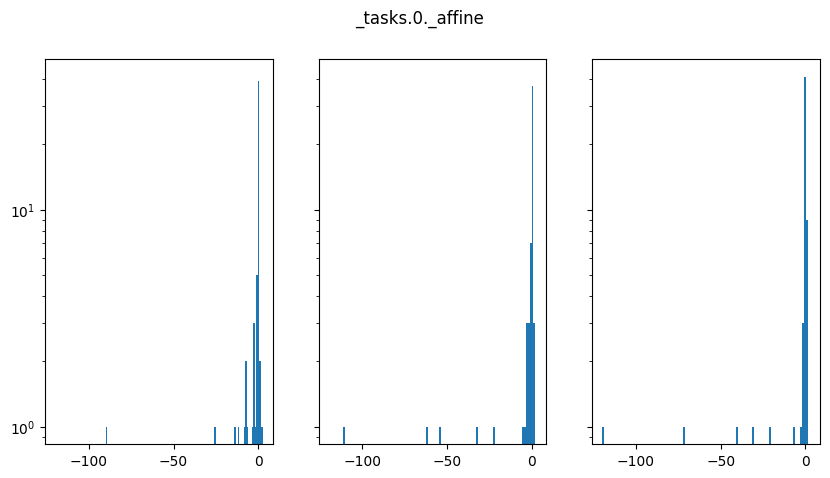

In [53]:
plt.close('all')
for layer_names, acts in zip(
    zip(*[activations[i].keys() for i in range(len(activations))]),
    zip(*[activations[i].values() for i in range(len(activations))])
):
    fig, axes = plt.subplots(1, len(acts), figsize=(10, 5), sharey=True, sharex=True)
    fig.suptitle(layer_names[0])
    print(layer_names[0], [a.shape for a in acts])
    print(layer_names[0], [a.min().item() for a in acts])
    print(layer_names[0], [a.max().item() for a in acts])
    for i, a in enumerate(acts):
        axes[i].hist(a.flatten().cpu().numpy(), bins=100)
        axes[i].set_yscale('log')

In [31]:
# _gnn._conv_layers.0.nn.0.weight
# _gnn._conv_layers.0.nn.2.weight
# _gnn._conv_layers.1.nn.0.weight
# _gnn._conv_layers.1.nn.2.weight
# _gnn._conv_layers.2.nn.0.weight
# _gnn._conv_layers.2.nn.2.weight
# _gnn._conv_layers.3.nn.0.weight
# _gnn._conv_layers.3.nn.2.weight
# _gnn._post_processing.0.weight 
# _gnn._post_processing.2.weight 
# _gnn._readout.0.weight torch.Si
# _tasks.0._affine.weight torch.S

In [54]:
for idx, (
    (layer0_name, fc_layer0_weight), 
    (layer1_name, fc_layer1_weight),
) in enumerate(zip(
    model_small_seed_0.named_parameters(), 
    model_small_mapped.named_parameters(),
)):
    with torch.no_grad():
        s1 = (((fc_layer0_weight.abs() ** 2).sum() ** 0.5) / ((fc_layer1_weight.abs() ** 2).sum() ** 0.5)).cpu().numpy()
        print(layer0_name, s1)

_gnn._conv_layers.0.nn.0.weight 1.0000128
_gnn._conv_layers.0.nn.2.weight 1.0000384
_gnn._conv_layers.1.nn.0.weight 1.0000591
_gnn._conv_layers.1.nn.2.weight 1.0000592
_gnn._conv_layers.2.nn.0.weight 1.0000592
_gnn._conv_layers.2.nn.2.weight 1.0000592
_gnn._conv_layers.3.nn.0.weight 1.0000592
_gnn._conv_layers.3.nn.2.weight 1.0000592
_gnn._post_processing.0.weight 1.0000587
_gnn._post_processing.2.weight 1.0000592
_gnn._readout.0.weight 1.0000385
_tasks.0._affine.weight 1.0000128


In [55]:
from icecube_utils import make_dataloader
from graphnet.training.labels import Direction

test_dataloader = make_dataloader(db = config_small['inference_database_path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = config_small['batch_size'],
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
)

In [56]:
next(iter(test_dataloader))

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [45756], which does not match the required output shape [7626, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [66114], which does not match the required output shape [11019, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resiz

DataBatch(x=[14517, 6], n_pulses=[100], features=[100], event_id=[100], muon=[100], muon_stopped=[100], noise=[100], neutrino=[100], v_e=[100], v_u=[100], v_t=[100], track=[100], dbang=[100], corsika=[100], zenith=[100], azimuth=[100], y=[14517], z=[14517], time=[14517], charge=[14517], auxiliary=[14517], direction=[100, 3], dataset_path=[100], batch=[14517], ptr=[101])

In [57]:
# from torchviz import make_dot

# x = next(iter(test_dataloader)).cpu()
# y = model_small_seed_0.cpu()(x)

# make_dot(sum(y) / len(y), params=dict(list(model_small_seed_0.named_parameters()))).render("rnn_torchviz", format="png")

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [55314], which does not match the required output shape [9219, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [63270], which does not match the required output shape [10545, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resiz

In [58]:
# def forward_wrapper(method):
#     def inner(*args, **kwargs):
#         return [y / 0.07381752204660513 for y in method(*args, **kwargs)]
#     return inner

# def wrap_it(wrapper, instance, method):
#     class_method = getattr(instance, method)
#     wrapped_method = wrapper(class_method)
#     setattr(instance, method, wrapped_method)

# wrap_it(forward_wrapper, model_small_mapped, 'forward')

In [59]:
resilts_small_seed_0, resilts_small_seed_1, resilts_small_mapped = [], [], []
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        resilts_small_seed_0.append(model_small_seed_0(batch.cuda()))
        resilts_small_seed_1.append(model_small_seed_1(batch.cuda()))
        resilts_small_mapped.append(model_small_mapped(batch.cuda()))
    if i > 100:
        break

graphnet: INFO     2023-03-04 16:55:24 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 16:55:24 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 16:55:24 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 16:55:24 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 16:55:25 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 16:55:25 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-03-04 16:55:25 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing struc

In [60]:
for a, b, c in zip(resilts_small_seed_0, resilts_small_seed_1, resilts_small_mapped):
    print(
        (np.abs(a[0].cpu().numpy()) ** 2).sum() ** 0.5, 
        (np.abs(b[0].cpu().numpy()) ** 2).sum() ** 0.5,
        (np.abs(c[0].cpu().numpy()) ** 2).sum() ** 0.5
    )

415.1028298807417 395.4519566268449 287.54426289703645
356.06117802984363 354.9598458804883 401.5413078065568
261.625059722879 287.632510223549 224.38006609879585
273.87912194524796 269.7960166959475 306.6246178146823
394.53584279504946 382.5785050156373 291.25724239922346
290.2545488446305 285.98535801680475 221.29218347865339
372.9481364747651 390.69669342086837 401.33737366460156
317.63808512991636 333.1295379615863 199.85963824644534
293.12480010654167 264.01910146332216 192.257334873081
347.22444110402137 347.68413511763805 275.5842940463045
279.6761799385139 308.02509790194046 203.3016347388776
453.7854325008682 405.0564003938217 323.7736236554794
270.57539961164247 276.2281665580105 243.79922579860667
276.6421283671379 302.54875640134435 226.29686151436127
295.9331639069876 343.06622902874017 260.81744992906437
241.39430593429498 220.11551477292554 113.81098554044553
305.54202605779125 337.022973067119 254.0335546241874
218.71107689426705 283.3425488697382 257.188130315145
316.5

In [61]:
vs = []
for a, b, c in zip(resilts_small_seed_0, resilts_small_seed_1, resilts_small_mapped):
    print(
        v := ((np.abs(c[0].cpu().numpy()) ** 2).sum() ** 0.5) / ((
            ((np.abs(a[0].cpu().numpy()) ** 2).sum() ** 0.5) +
            ((np.abs(b[0].cpu().numpy()) ** 2).sum() ** 0.5)
        ) / 2)
    )
    vs.append(v)

0.7094998825087935
1.1294780162708546
0.8170304002207227
1.1279699806801087
0.7495865781394035
0.7680557380482367
1.0511100395178528
0.6142273559861586
0.690153241671883
0.7931526634617317
0.6918536419928245
0.7539773011852815
0.8917250759954435
0.7814241123798696
0.8163308222588501
0.49321154365053754
0.790685938294641
1.024544459463932
0.6544289494620227
0.9033842839912781
0.5773992106602941
0.4957084303696881
0.7542449606918749
0.7127954278756666
0.7460334845522205
0.714311691777461
1.072055738102952
1.111052167720507
0.7843813210192969
0.811046358974372
0.7830590785773607
0.8037547794112327
0.8796140634220286
0.5668423397178335
0.7576068517935599
0.9234561295406962
0.9206132470186901
0.9527990547291005
0.6286900083566948
0.7777572463405934
0.8897777965719629
0.796414084144502
0.6947719084715006
0.893455400273731
0.6485835827669993
0.5325719032875783
0.7390418124160028
0.7383250091695478
0.9222883659576044
1.0009730758843545
0.637504794569963
0.9284484172043839
0.8477575791489683
0.

In [62]:
sum(vs) / len(vs)

0.7726519818677406

## Inference & Evaluation

With a trained model loaded into memory, we can now apply the model to batch_51. The following cells will start inference (or load in a csv with predictions, if you're in a hurry) and plot the results. 

In [67]:
def convert_to_3d(df: pd.DataFrame) -> pd.DataFrame:
    """Converts zenith and azimuth to 3D direction vectors"""
    df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
    df['true_y'] = np.sin(df['azimuth']) * np.sin(df['zenith'])
    df['true_z'] = np.cos(df['zenith'])
    return df

def calculate_angular_error(df : pd.DataFrame) -> pd.DataFrame:
    """Calcualtes the opening angle (angular error) between true and reconstructed direction vectors"""
    df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
    return df

In [68]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(model_small_seed_0, config_small))) 
df.to_hdf('results/small_0.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   7%|▋         | 141/2000 [00:09<02:00, 15.40it/s]

In [ ]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(model_small_seed_1, config_small))) 
df.to_hdf('results/small_1.h5', key='df', mode='w')

NameError: name 'calculate_angular_error' is not defined

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large, config_large)))
# df.to_hdf('results/large.h5', key='df', mode='w')

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_random, config_large_random)))
# df.to_hdf('results/large_random.h5', key='df', mode='w')

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_mapped, config_large)))
# df.to_hdf('results/large_mapped.h5', key='df', mode='w')

In [ ]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(model_small_mapped, config_small)))
df.to_hdf('results/mapped_gromov.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:21<00:00, 14.18it/s]
graphnet: INFO     2023-03-04 14:06:03 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [48]:
results = {
    'small_0': pd.read_hdf('results/small_0.h5', key='df'),
    'small_1': pd.read_hdf('results/small_1.h5', key='df'),
    'mapped_gromov': pd.read_hdf('results/mapped_gromov.h5', key='df'),
}

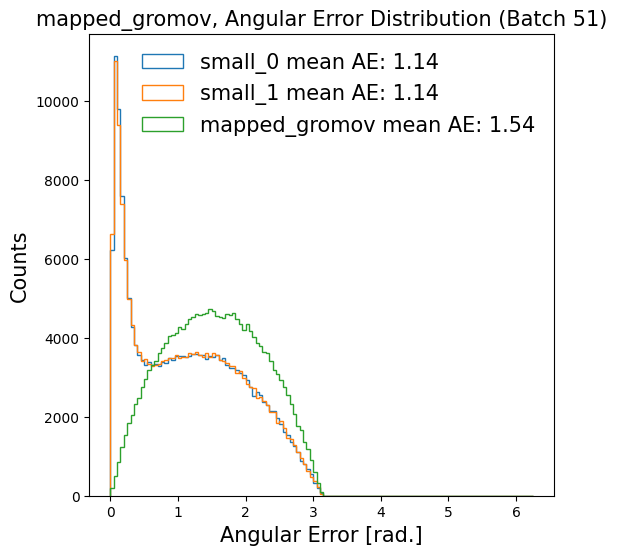

In [49]:
fig = plt.figure(figsize = (6,6))
for name, result in results.items():
    plt.hist(result['angular_error'], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'{name} mean AE: {np.round(result["angular_error"].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon = False, fontsize = 15)

So the pre-trained dynedge seems to perform quite well. Another interesting feature of the reconstruction is that dynedge (when coupled with the[ DirectionReconstructionWithKappa](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/models/task/reconstruction.py#L45) is that dynedge estimated *kappa* the concentration parameter from the vonMisesFisher distribution. Kappa is analogus to sigma via sigma = 1/sqrt(kappa), and the quality of the direction estimate should be highly correlated with this parameter. 

In [ ]:
cut_threshold = 0.5
for name, result in results.items():
    fig = plt.figure(figsize = (6,6))
    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) <= cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma <= {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) <= cut_threshold].mean(),2)}')

    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) > cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma > {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) > cut_threshold].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
    plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
    plt.legend(frameon = False, fontsize = 15)

As you can see, the variable can be used to distinguish "good" and "bad" reconstructions with some confidence. 

## A few hints for your neutrino data science journey!

* The configuration of dynedge shown in this notebook is the so-called "baseline". It's not optimized for high energy neutrinos, so you might be able to squeeze out a bit more performance by tuning hyperparameters or making larger modifications; such as switching out the learning rate scheduler or choosing a different loss function, etc.

* You can use the kappa variable to group events into different categories. Perhaps training a seperate reconstruction method for each performs better?

* You may want to adjust the [ParquetDataset](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/data/parquet/parquet_dataset.py#L11) such that it works with the competition data. This would allow you to train / infer directly on the competition files (No conversion to sqlite needed). Feel free to contribute this to the repository!


Good luck!